### Clean and Package X, y Data for Model Fitting
PB 1/18/2023

In [85]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# Note: Grass Biomass processed data goes to:
# /n/davies_lab/Lab/shared_projects/GrassBiomass/data/out
# Rsync them from there to the ./data/out folder for filepaths to be correct

# # # USER INPUTS

# regions = ['Mpala', 'Kruger']
region = 'Mpala'
# region = 'Kruger'

# SET unique label for this run (i.e. the date, "initial", "spicy", etc.)

# initial run, groundthres = 5 cm
# label = "initial" 

# Spicy corresponding to the one where metrics are calculated
# ONLY using the grass layer points, and groundthres = 2cm
label = "spicy" 


# # # END USER INPUTS


In [ ]:
# Load X Data
metricdir = Path(f'./data/out/')

# Print files in folder (just for reference
# for f in metricdir.joinpath(region).glob('*'):
    # print(f)

coverd1 = pd.read_csv(metricdir.joinpath(f'{label}/{region}').joinpath('CoverD1.csv'), index_col=0)
coverd2 = pd.read_csv(metricdir.joinpath(f'{label}/{region}').joinpath('CoverD2.csv'), index_col=0)
coverd2byH = pd.read_csv(metricdir.joinpath(f'{label}/{region}').joinpath('CoverD2byH.csv'), index_col=0)
complexity = pd.read_csv(metricdir.joinpath(f'{label}/{region}').joinpath('ComplexityMetrics.csv'), index_col=0)
perc = pd.read_csv(metricdir.joinpath(f'{label}/{region}').joinpath('PercentileHeights.csv'), index_col=0)
PAI = pd.read_csv(metricdir.joinpath(f'{label}/{region}').joinpath('FHPD2.csv'), index_col=0)
npulses = pd.read_csv(metricdir.joinpath(f'{label}/{region}').joinpath('Npulses.csv'), index_col=0)

# Open & Format y dataset for merging

# Note need to cut some blank lines from the mpala y data file
if region == 'Mpala':
    
    BiomassData = pd.read_csv(Path('./data/in/Mpala2022/MpalaGrassBiomassSurveys2022Curated.csv'))
    BiomassData = BiomassData[0:193]
    
    # Add id column to merge with x data later
    BiomassData['id'] = BiomassData['GPS #'].apply(lambda x: int(x))
    
if region == 'Kruger':
    BiomassData = pd.read_csv(Path('./data/in/LowerSabie2022/KrugerLowerSabie2022GrassBiomassCurated.csv'))
    BiomassData = BiomassData[0:60]
    
    # Make an index col for each row for kruger
    BiomassData['id'] = BiomassData['Plot #']

In [86]:
BiomassData.columns

Index(['Plot #', 'GPS #', 'Date Harvested', '% Cover', 'Height 1', 'Height 2',
       'Height 3', 'Height 4', 'Average Height', 'Wet Weight (g)',
       'Dry Weight (g)', 'Site', 'Type', 'Tree Species', 'Bag Size',
       'Average Bag Weight (g)', 'Wet Weight Without Bag (g)',
       'Dry Weight Without Bag (g)', 'Water Weight (g)', 'Max Height (cm)',
       'Max Height (m)', 'id'],
      dtype='object')

In [103]:
# # PLots for Testing 
# if region == 'Mpala':
    
#     featid = 'Mpala01-4'
# else:
#     featid = 'KrugerLowerSabie2022-A11'

# # Test plot of mpala cover data
# fig, ax = plt.subplots()
# ax.plot(coverd2byH[featid], coverd2byH[featid].index)
# ax.plot(coverd2[featid], coverd2[featid].index)

# # Add herbaceous layer height
# ax.hlines(complexity[featid].loc['herbh'], xmin=0, xmax=0.9)
# ax.set_ylim(-0.1, 2)


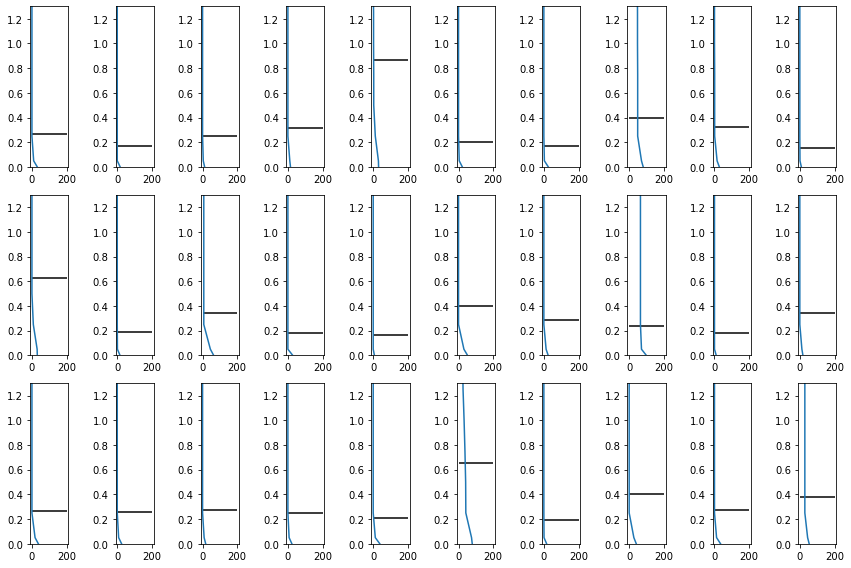

In [104]:
# Plots of pulses by height with herbh 
fig, axes = plt.subplots(nrows=3, ncols=10, figsize=(12, 8))

axes_list = [ax for row in axes for ax in row]

ids = [featid for featid in npulses.keys()]

for ax, featid in zip(axes_list, ids[:30]):
    
        # add every single subplot to the figure with a for loop
        ax.plot(npulses[featid], npulses[featid].index)

        # Add herbaceous layer height
        ax.hlines(complexity[featid].loc['herbh'], xmin=0, xmax=200, color='k')
        
        ax.set_ylim(0, 1.3)
        
plt.tight_layout()
plt.show()


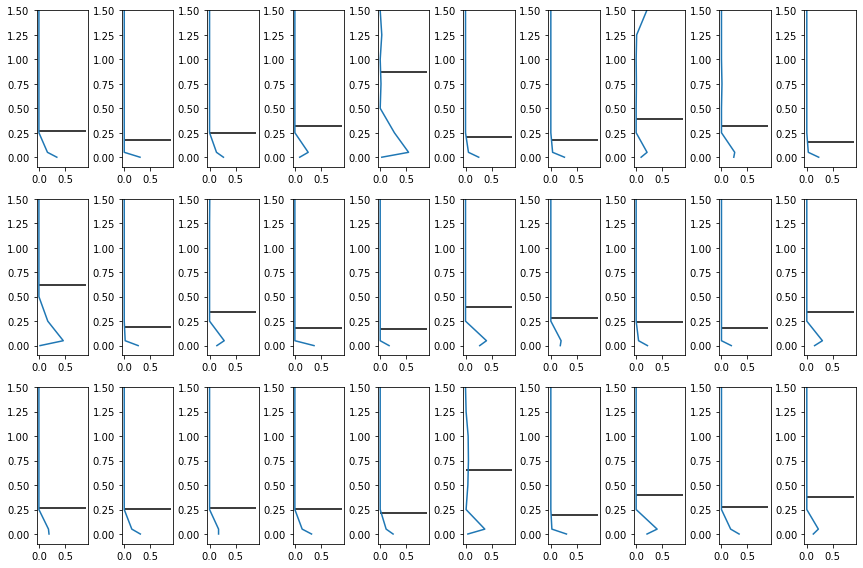

In [92]:
# Plots of coverd2 by height with herbh 
fig, axes = plt.subplots(nrows=3, ncols=10, figsize=(12, 8))

axes_list = [ax for row in axes for ax in row]

ids = [featid for featid in npulses.keys()]

for ax, featid in zip(axes_list, ids[:30]):
    
    ax.plot(coverd2byH[featid], coverd2byH[featid].index)
    # ax.plot(coverd2[featid], coverd2[featid].index)

    # Add herbaceous layer height
    ax.hlines(complexity[featid].loc['herbh'], xmin=0, xmax=0.9, color='k')
    ax.set_ylim(-0.1, 1.5)
        
plt.tight_layout()
plt.show()


In [93]:
# Make a cover within the herbaceous layer dictionary
# Uses the caluclated herbaceous layer height to only grab cover from the top and bottom of the grass layer
cherb_dict = {'featureid':[],
              'id':[],
              'coverherb_0m':[],
              'coverherb_5cm':[],
              'cover_0m':[],
              'cover_5cm':[]}

for featid in coverd2.columns:
    
    herbh = complexity[featid].loc['herbh']

    # find indices with 2 closest values to herbh
    i = np.argsort(np.abs(coverd2.index - herbh))

    coverd2.index[i[0:2]]

    # Interpolate a cover value at the herbh
    chmax = np.interp(herbh, xp=coverd2.index, fp=coverd2[featid])

    # Get cover value at bottom
    chmin = coverd2[featid].iloc[0]

    # Also, calc at ground level (0.05 m)
    chmin_ground = coverd2[featid].iloc[1]

    # Get total cover within herbaceous layer
    # test both ground and non-ground
    cherb = chmin - chmax
    cherb_ground = chmin_ground - chmax
    
    # Append to dict
    cherb_dict['featureid'].append(featid)
    if region == 'Mpala':
        cherb_dict['id'].append(int(featid.split('-')[1]))
    elif region =='Kruger':
        cherb_dict['id'].append(featid.split('-')[1])
    cherb_dict['coverherb_0m'].append(cherb)
    cherb_dict['coverherb_5cm'].append(cherb_ground)
    cherb_dict['cover_0m'].append(chmin)
    cherb_dict['cover_5cm'].append(chmin_ground)

cherb_df = pd.DataFrame(cherb_dict)
cherb_df_t = cherb_df.transpose()
cherb_df_t.columns = cherb_df['featureid']
cherb_df_t.head()

featureid,Mpala01-13,Mpala01-1,Mpala01-2,Mpala01-3,Mpala01-4,Mpala01-5,Mpala01-6,Mpala01-7,Mpala01-8,Mpala01-9,...,Mpala15-192,Mpala15-193,Mpala15-194,Mpala15-195,Mpala15-196,Mpala15-197,Mpala15-200,Mpala15-198,Mpala15-199,Mpala07-121
featureid,Mpala01-13,Mpala01-1,Mpala01-2,Mpala01-3,Mpala01-4,Mpala01-5,Mpala01-6,Mpala01-7,Mpala01-8,Mpala01-9,...,Mpala15-192,Mpala15-193,Mpala15-194,Mpala15-195,Mpala15-196,Mpala15-197,Mpala15-200,Mpala15-198,Mpala15-199,Mpala07-121
id,13,1,2,3,4,5,6,7,8,9,...,192,193,194,195,196,197,200,198,199,121
coverherb_0m,0.508197,0.303571,0.398571,0.348837,0.855725,0.297425,0.282437,0.304762,0.490909,0.243963,...,0.015625,0.051724,0.0,0.0,0.189026,0.0625,0.0,0.024096,0.0,0.362319
coverherb_5cm,0.163934,0.0,0.131905,0.255814,0.825422,0.043904,0.021073,0.209524,0.254545,0.015392,...,0.0,0.0,0.0,0.0,0.03347,0.0,0.0,0.0,0.0,0.0
cover_0m,0.508197,0.303571,0.4,0.348837,0.893939,0.309859,0.295455,0.561905,0.5,0.257143,...,0.117188,0.051724,0.045455,0.0,0.2,0.0625,0.013889,0.47992,0.0,0.362319


In [94]:
# Format percentile metric df for merging
perc_t = perc.transpose()
if region == 'Mpala':
    perc_t['id'] = [int(i.split('-')[-1]) for i in perc_t.index]
elif region =='Kruger':
        perc_t['id'] = [i.split('-')[-1] for i in perc_t.index]
perc_t.head()

,0,25,50,75,98,100,mean,std,id
Mpala01-13,0.050984,0.054362,0.059458,0.063149,0.081209,0.082254,0.061687,0.009864,13
Mpala01-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
Mpala01-2,0.053160,0.055253,0.056518,0.061774,0.074713,0.075838,0.060509,0.008965,2
Mpala01-3,0.050839,0.073447,0.110451,0.181671,0.206761,0.209809,0.121244,0.056650,3
Mpala01-4,0.053720,0.151243,0.196326,0.275715,1.270814,1.302914,0.280978,0.281088,4


In [95]:
# Make complexity for Merging
complexity_t = complexity.transpose()
if region == 'Mpala':
    complexity_t['id'] = [int(i.split('-')[-1]) for i in complexity_t.index]
elif region =='Kruger':
    complexity_t['id'] = [i.split('-')[-1] for i in complexity_t.index]

In [96]:
# Make PAI for merging

# OLD WAY commented out 1/23
# Get rid of inf values (-0)
# Also, limit to sum above 5 cm 
# PAI = PAI.iloc[1:].applymap(lambda x: 0 if x==-0 else x)

# Undoing the log(pgap)/dz here (where dz = 0.25 m) 
# and dividing by k=0.5 instead (spherical leaf angle dist.)
# Also, only taking PAI values above 0.05 m (iloc[1:])
# PAI_lim = PAI.iloc[1:].applymap(lambda x: (x*0.25)/0.5)

# REMAKE PAI here
coverd2byH_v2 = coverd2.apply(lambda x: np.abs(np.diff(x)), axis=0)
PAI_v2 = coverd2byH_v2.applymap(lambda x: -np.log(1 - x)/0.5 if x > 0 else x)

if region == 'Mpala':
    
    PAIsum_dict = {'PAIsum_0m': list(PAI_v2.sum(axis=0)),
                   'PAIsum_5cm': list(PAI_v2.iloc[1:].sum(axis=0)),
                   'PAIsum_0mto1p5m': list(PAI_v2.iloc[:8].sum(axis=0)),
                   'PAIsum_5cmto1p5m': list(PAI_v2.iloc[1:8].sum(axis=0)),
                   'PAImean_0mto1p5m': list(PAI_v2.iloc[:8].mean(axis=0)),
                   'PAImean_5cmto1p5m': list(PAI_v2.iloc[1:8].mean(axis=0)),
                    'id': [int(c.split('-')[-1]) for c in PAI_v2.columns]}
    
elif region =='Kruger':
    
    PAIsum_dict = {'PAIsum_0m': list(PAI_v2.sum(axis=0)),
                   'PAIsum_5cm': list(PAI_v2.iloc[1:].sum(axis=0)),
                   'PAIsum_0mto1p5m': list(PAI_v2.iloc[:8].sum(axis=0)),
                   'PAIsum_5cmto1p5m': list(PAI_v2.iloc[1:8].sum(axis=0)),
                   'PAImean_0mto1p5m': list(PAI_v2.iloc[:8].mean(axis=0)),
                   'PAImean_5cmto1p5m': list(PAI_v2.iloc[1:8].mean(axis=0)),
                    'id': [c.split('-')[-1] for c in PAI_v2.columns]}

PAIdf = pd.DataFrame(PAIsum_dict)

/tmp/ipykernel_6442/2010116118.py:15: RuntimeWarning: divide by zero encountered in log
  PAI_v2 = coverd2byH_v2.applymap(lambda x: -np.log(1 - x)/0.5 if x > 0 else x)


In [100]:
# # # MERGE ALL METRICS TOGETHER

# make xy dataframe, including percentile heights and cover metrics
XYdf = pd.merge(cherb_df, BiomassData)
# Add in percentile metrics (by merging on 'id' col)
XYdf = pd.merge(XYdf, perc_t)
# Add in complexity metrics
XYdf = pd.merge(XYdf, complexity_t)
# add in PAI
XYdf = pd.merge(XYdf, PAIdf)

# Add a log column
if region == 'Mpala':

    XYdf['log(DryWeight)'] =  XYdf['Dry Weight Without Bag (g)'].apply(lambda x: np.log(x) if x>0 else x)

elif region == 'Kruger':
    
    XYdf['log(DryWeight)'] =  XYdf['Dry Weight (g)'].apply(lambda x: np.log(x) if x>0 else x)

In [105]:
# XYdf.columns

In [102]:
# Save (using region)
XYdf.to_csv(f'./data/out/{label}/{region}/XYdata.csv')

### Extras - Plotting, Printing metrics, etc.

In [36]:
# XYdf[XYdf['mean'] == 0]

In [37]:
# featids_shortgrass = [f for f in XYdf[XYdf['mean'] == 0].featureid]

In [ ]:
# XYdf[XYdf['mean'] == 0].mean()

In [83]:
# for f in metricdir.joinpath(region).glob('*'):
#     print(f)

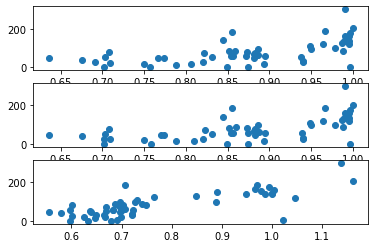

In [77]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

if region == 'Mpala':
    
    # Dry Weight Without Bag (g)
    ax1.scatter(XYdf.coverherb_5cm,
                XYdf['Dry Weight Without Bag (g)'],
                c=XYdf['Water Weight (g)'])

    ax2.scatter(XYdf.cover_5cm,
                XYdf['Dry Weight Without Bag (g)'],
                c=XYdf['Water Weight (g)'])

    ax3.scatter(XYdf['herbh'],
                XYdf['Dry Weight Without Bag (g)'],
                c=XYdf['Water Weight (g)'])
    
    
if region == 'Kruger':
    
    # Dry Weight Without Bag (g)
    ax1.scatter(XYdf.coverherb_5cm,
                XYdf['Dry Weight (g)'])

    ax2.scatter(XYdf.cover_5cm,
                XYdf['Dry Weight (g)'])

    ax3.scatter(XYdf['herbh'],
                XYdf['Dry Weight (g)'])

In [80]:
# fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
# # Dry Weight Without Bag (g)
# ax1.scatter(XYdf.coverherb_5cm,
#             XYdf['Wet Weight Without Bag (g)'],
#             c=XYdf['Water Weight (g)'])

# ax2.scatter(XYdf.cover_5cm,
#             XYdf['Wet Weight Without Bag (g)'],
#             c=XYdf['Water Weight (g)'])

# ax3.scatter(XYdf['mean'],
#             XYdf['Wet Weight Without Bag (g)'],
#             c=XYdf['Water Weight (g)'])

In [81]:
# fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
# # Dry Weight Without Bag (g)
# ax1.scatter(XYdf.coverherb_5cm,
#             XYdf['log(DryWeight)'],
#             c=XYdf['Water Weight (g)'])

# ax2.scatter(XYdf.cover_5cm,
#             XYdf['log(DryWeight)'],
#             c=XYdf['Water Weight (g)'])

# ax3.scatter(XYdf['mean'],
#             XYdf['log(DryWeight)'],
#             c=XYdf['Water Weight (g)'])

In [22]:
# MI.loc['Dry Weight Without Bag (g)']

In [23]:
# MI.loc['Wet Weight Without Bag (g)']

In [82]:
# corr = pairwise_corr(XYdf.select_dtypes(include=np.number), drop_nan=True)

In [ ]:
# corr.loc['Dry Weight Without Bag (g)']

In [ ]:
# corr.loc['Wet Weight Without Bag (g)']

In [ ]:
# corr.loc['log(DryWeight)'].sort_values(ascending=False)

In [ ]:
# corr.loc['Dry Weight Without Bag (g)'].sort_values(ascending=False)

In [ ]:
# Check on cherb cover values vs regular cover values

In [ ]:
# plt.scatter(cherb_df['cover_0m'], cherb_dict['coverherb_0m'])

In [ ]:
# plt.scatter(cherb_df['cover_5cm'], cherb_dict['coverherb_5cm'])

In [ ]:
# coverd2.transpose().head()

In [ ]:
# sns.histplot(complexity.loc["nlayers"])

In [ ]:
# sns.histplot(complexity.loc["herbh"])

In [ ]:
# complexity.head()